[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IshmaGurca/AtomicNite/blob/main/notebooks/VoG.ipynb)

# VARIANCE OF GRADIENTS

Machine learning models are optimized to generalize the distribution of the training data. This leads to the effect that models tend to underperform on "out-of-distribution" data or even on examples that are close to the edge of the training distribution.

A common approach to mitigate such problems is to adjust the training data for examples b balancing the dataset for underrepresented examples. 
But in practice this is often not feasible since the skewness of the data is not easy to detect or the distribution of the live data changes over time.

Therefore it is desirable to detect the quality/uncertainty of the prediction to ensure that the model does not produce complete wrong results.
To measure such uncertainty differrent measures/approaches are used e.g.:

- Maximum Softmax Probability
- Ensembling of Multiple Models:
- Monte-Carlo Dropout or Test-Time Dropout

More information: https://medium.com/analytics-vidhya/out-of-distribution-detection-in-deep-neural-networks-450da9ed7044


In the paper ESTIMATING EXAMPLE DIFFICULTY USING VARIANCE OF GRADIENTS by Chirag Agarwal and Sara Hooker (https://arxiv.org/pdf/2008.11600.pdf) a new approach is proposed.
Their work starts with the simple hypothesis - examples that a model has difficulty learning will exhibit
higher variance in gradient updates over the course of training. While the gradient updates
for the relatively easier examples are expected to stabilize early in training and converge to a narrow range of
values.

The complexity of the learned examples seems to show a correlation with the quality of the prediction and therefore might be a alternative to the other uncertainty measures. We want to explore this proposed quality of the VoG in this notebooks further.


DISCLAIMER:

This code is not fully tested and only for demonstration purposes ;) 

In [1]:
!pip install torch torchvision

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy 

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
import torchvision

In [3]:
### Set random set for pytorch model
seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

As testing data we use the MNIST dataset and skew the data artificial by underrepresenting "5" in the training data set.

In [4]:
### Load MNIST dataset

DATA_FOLDER = '../data'

mnist_train = torchvision.datasets.MNIST(DATA_FOLDER, download=True,train=True,
    transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
mnist_test = torchvision.datasets.MNIST(DATA_FOLDER, download=True,train=False,
    transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [5]:
### Skew the MNIST dataset
TRAIN_SIZE = 10000
TEST_SIZE = 5000
BATCH_SIZE = 100

mnist_train_subset= Subset(mnist_train,list(WeightedRandomSampler((mnist_train.targets != 5) *0.9 + (mnist_train.targets == 5) *0.1, TRAIN_SIZE, replacement=False)))
mnist_test_subset = Subset(mnist_test,list(WeightedRandomSampler((mnist_test.targets == 5) *0.99 + (mnist_test.targets != 5) *0.01, TEST_SIZE, replacement=False)))

In [6]:
### Set up data loader
dataloader_train = DataLoader(mnist_train_subset, shuffle=True, batch_size=BATCH_SIZE)
dataloader_train_full = DataLoader(mnist_train_subset, shuffle=True, batch_size=TRAIN_SIZE)
dataloader_test = DataLoader(mnist_test_subset, shuffle=False, batch_size=1)
dataloader_test_full = DataLoader(mnist_test, shuffle=False, batch_size=TEST_SIZE)

We can clearly see we have only a sparse training examples for the label "5", which will make it harder for the trained network to predict this label correctly in the future.

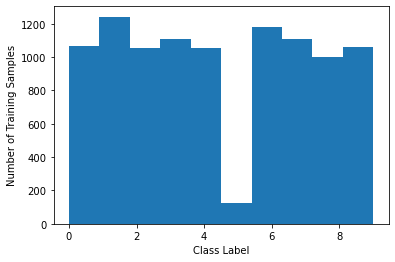

In [7]:
x,y = next(iter(dataloader_train_full))
plt.hist(y.numpy())
plt.ylabel('Number of Training Samples')
plt.xlabel('Class Label')
plt.show()

We define a simple feedforward network to classify the images.

In [8]:

class EmbNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = 20
        self.lin = torch.nn.Linear(28*28,self.hidden)
        self.bn = torch.nn.BatchNorm1d(self.hidden)

    def forward(self,x):
        x = x.reshape(x.shape[0],28*28)
        x = self.lin(x)
        #x = torch.sigmoid(x)
        x = self.bn(x)
        return x

class Classification_Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_hidden = 20
        self.hidden = 20
        self.lin1 = torch.nn.Linear(self.emb_hidden,self.hidden)
        self.lin2a = torch.nn.Linear(self.hidden,self.hidden)
        self.lin2b = torch.nn.Linear(self.hidden,10)
         
    def  forward(self,x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2a(x)
        x = torch.relu(x)
        x = self.lin2b(x)
        return x

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_net = EmbNet()
        self.net = Classification_Net()

    def forward(self,x):
        x_emb = self.emb_net(x)
        x = self.net(x_emb)
        return x, x_emb

network = Net()

Will training the network we will already store the weights after each EPOCH in a separate list to be able to retrive this info later on.

In [9]:
### Train network
saved_models = []
EPOCHS = 10

para =   list(network.parameters())
optimizer = torch.optim.Adam(para,lr = 0.1)

for _ in range(EPOCHS):
    for x,y in dataloader_train:
        y_hat,_ = network(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    #### SAVE CHECKPOINTS OF MODEL
    saved_models.append(deepcopy(network.state_dict()))


Let's evaluate our trained model on a test example. We see the model is unable to correctly predict the "5" as label 

Actual Label: 5


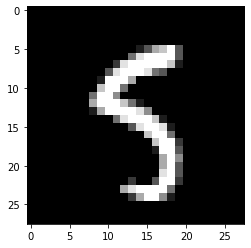

Predicted Label: 4


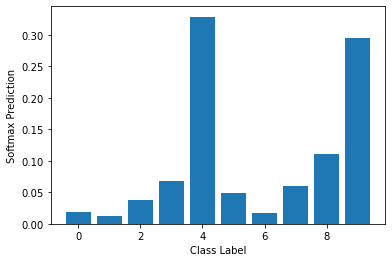

In [10]:
### Test MODEL
network.eval()
X_test, y_test = next(iter(dataloader_test))


print('Actual Label: {}'.format(y_test.detach().numpy()[0]))

plt.imshow(X_test[0].reshape(28,28), cmap="gray")
plt.show()

y_test_hat,_ = network(X_test)
y_test_sf = torch.nn.functional.softmax(y_test_hat, dim=1).detach().numpy()[0]

print('Predicted Label: {}'.format(np.argmax(y_test_sf)))

plt.bar(x = [i for i in range(10)], height= y_test_sf)

plt.ylabel('Softmax Prediction')
plt.xlabel('Class Label')
plt.show()

As defined in the paper we implement the function to calculate the Variance of Gradient for a given dataset. We therefore:

- Load the weights of the model after each EPOCH
- Evaluate the model for the example data in this state
- Calculate the gradient of the estimated output in respect to the input
- Determin the variance of the gradients in respect to the differrent EPOCHS
- Finally average the VoG accross al input data points

In [11]:
### Define Variation of Gradient
def VoG(x, saved_models):
    x.requires_grad = True
    grads = []
    for net_dict in saved_models:
        network.load_state_dict(net_dict)
        y_test_hat,_ =  network(x)
        m,_ = torch.max(y_test_hat,axis=-1)
        grad = torch.autograd.grad(m, x,grad_outputs=torch.ones(m.size()))
        grads.append(grad[0])
        #x.grad.zero_()

    grad_stack = torch.stack(grads)
    grad_stack = grad_stack.reshape(grad_stack.shape[0],grad_stack.shape[1],28*28).transpose(1,0)
    return torch.mean(torch.mean((grad_stack- torch.mean(grad_stack,axis=1, keepdim=True))**2,axis=1),axis=-1)


In [12]:
vog_test = VoG(X_test,saved_models)
print('Variance of Gradient: {}'.format(vog_test.detach().numpy()[0]))

Variance of Gradient: 0.010787789709866047


Let's now calculate the VoG for the complete test dataset.

In [13]:
### Accuracy vs variation of gradient

X_1000,y_1000 = next(iter(dataloader_test_full))
vog = VoG(X_1000,saved_models)

y_1000_hat, _ = network(X_1000)
loss = torch.nn.functional.cross_entropy(y_1000_hat, y_1000,reduction='none')
tf = (torch.argmax(y_1000_hat,axis=-1) == y_1000).detach().numpy()

First we clearly see that for the "5" class our model performs worse (as expected)

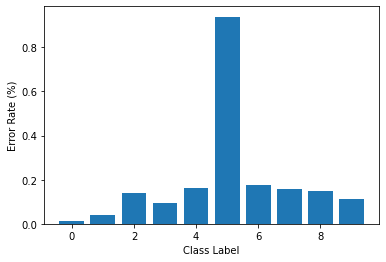

In [14]:
##### Error per class
errors = []
for i in range(10):
    tf_class = tf[y_1000==i]
    err = 1- np.sum(tf_class)/(len(tf_class))
    errors.append(err)
plt.bar([i for i in range(10)],height = errors)
plt.ylabel('Error Rate (%)')
plt.xlabel('Class Label')
plt.show()


If we comapare the classification error in correlation with the VOG we see at least a weak correlation. The results in this very simple example seem not as promising as in the paper.

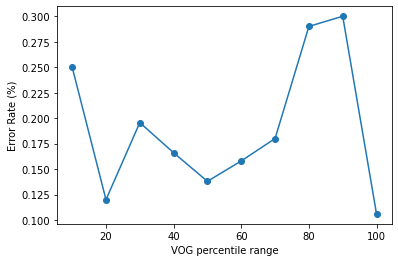

In [15]:
vog_np = vog.detach().numpy()
l = len(vog_np)
vog_arg_sort = np.argsort(vog_np)
errors = []

for i in range(1,11):
    start_i = int(l*(i/10-0.1))
    end_i = int(l*(i/10))
    err = 1- np.sum(tf[vog_arg_sort[start_i:end_i]])/(end_i - start_i)
    errors.append(err)

plt.plot([i*10 for i in range(1,11)],errors,'o-')
plt.ylabel('Error Rate (%)')
plt.xlabel('VOG percentile range')
plt.show()

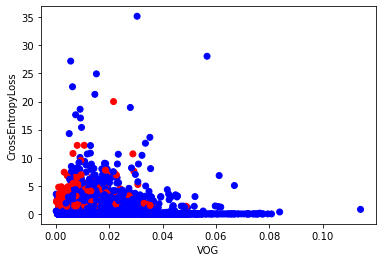

In [16]:
plt.scatter(y = loss.detach().numpy(), x= vog.detach().numpy(),color=['b' if i != 5 else 'r' for i in y_1000])
plt.ylabel('CrossEntropyLoss')
plt.xlabel('VOG')
plt.show()